In [22]:
import matplotlib.pylab as plt
import numpy as np
import time

import torch
from torch.autograd import Variable
import torch.nn as nn
import torchvision.datasets as dset
import torchvision.transforms as transforms
import torch.nn.functional as F
import torch.optim as optim

import matplotlib

%matplotlib inline
%config InlineBackend.figure_format='retina'
plt.style.use('ggplot') 

#font = {'family':'Osaka'}
font = {'family': 'IPAexGothic'}
matplotlib.rc('font', **font)

### Download MNIST-Samples

In [2]:
root = './data'
download = False
trans = transforms.Compose([transforms.ToTensor(),])# transforms.Normalize((0.5,), (1.0,))])
train_set = dset.MNIST(root=root, train=True, transform=trans, download=download)
test_set = dset.MNIST(root=root, train=False, transform=trans)
#test_set = dset.MNIST(root=root, train=True, transform=trans)

batch_size = 5
kwargs = {'num_workers': 1, 'pin_memory': True}
train_loader = torch.utils.data.DataLoader(
                 dataset=train_set,
                 batch_size=batch_size,
                 shuffle=True)
                 #, **kwargs)
test_loader = torch.utils.data.DataLoader(
                dataset=test_set,
                batch_size=batch_size,
                shuffle=False)
                #, **kwargs)

print('==>>> total trainning batch number: {}'.format(len(train_loader)))
print('==>>> total testing batch number: {}'.format(len(test_loader)))

==>>> total trainning batch number: 12000
==>>> total testing batch number: 2000


In [3]:
print(train_set.train_data.size())

torch.Size([60000, 28, 28])


### Definition of the model

In [4]:
class Net(nn.Module):
 
    def __init__(self):
        super(Net, self).__init__()
        # 1 input image channel, 6 output channels, 5x5 square convolution kernel
        self.conv1 = nn.Conv2d(1, 6, 5)
        self.conv2 = nn.Conv2d(6, 16, 3)
        self.fc1   = nn.Linear(16 * 5 * 5, 120)  # an affine operation: y = Wx + b
        self.fc2   = nn.Linear(120, 84)
        self.fc3   = nn.Linear(84, 10)
 
    def forward(self, x):
        # (1; 28, 28) -> (6; 24, 24) -> (6; 12, 12)
        x = F.max_pool2d(F.relu(self.conv1(x)), (2, 2))  # Max pooling over a (2, 2) window
        
        # (6; 12, 12) -> (6; 10, 10) -> (16; 5, 5)
        x = F.max_pool2d(F.relu(self.conv2(x)), 2)  # If the size is a square you can only specify a single number
        
        # (16; 5, 5) ->[16*5*5]
        x = x.view(-1, self.num_flat_features(x))
        
        # [16*5*5] -> [120]
        x = F.relu(self.fc1(x))
        
        # [120] -> [84]
        x = F.relu(self.fc2(x))
        
        # [84] -> [10]
        x = self.fc3(x)
        return x
 
    def num_flat_features(self, x):
        size = x.size()[1:]  # all dimensions except the batch dimension
        num_features = 1
        for s in size:
            num_features *= s
        return num_features

### Variables
You must choose these values carefully.

In [5]:
learning_rate = 0.001
num_epochs = 5
momentum = 0.9
num_miss_checks = 5

### Settings

In [6]:
net = Net()
#print(net)

In [7]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=learning_rate, momentum = momentum)

In [8]:
params = list(net.parameters())
print(len(params))
print(params[0].size())

10
torch.Size([6, 1, 5, 5])


### Training the Network

In [12]:
a = []
a.append(1)
a.append(3)
a.append(2)
a

[1, 3, 2]

In [17]:
t_start = time.time()
loss_fns = []

for epoch in range(num_epochs):  # データセットに渡り複数回ループ
 
    running_loss = 0.0
    for i, data in enumerate(train_loader, 0):
        # 入力を得る
        inputs, labels = data
 
        # それらを Variable にラップする
        inputs, labels = Variable(inputs), Variable(labels)
 
        # parameter 勾配をゼロにする
        optimizer.zero_grad()
 
        # forward + backward + optimize
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
 
        # 統計表示
        running_loss += loss.data[0]
        if i % 2000 == 1999:    # 2000 ミニバッチ毎に出力
            print('[%d, %5d] loss: %.3f' % (epoch+1, i+1, running_loss / 2000))
            loss_fns.append(running_loss / 2000)
            running_loss = 0.0

print('Finished Training')

t_end = time.time()

print('Time for training : {} sec'.format(t_end - t_start))

[1,  2000] loss: 1.708
[1,  4000] loss: 0.380
[1,  6000] loss: 0.195
[1,  8000] loss: 0.134
[1, 10000] loss: 0.126
[1, 12000] loss: 0.099
[2,  2000] loss: 0.082
[2,  4000] loss: 0.087
[2,  6000] loss: 0.076
[2,  8000] loss: 0.080
[2, 10000] loss: 0.068
[2, 12000] loss: 0.061
[3,  2000] loss: 0.059
[3,  4000] loss: 0.063
[3,  6000] loss: 0.052
[3,  8000] loss: 0.048
[3, 10000] loss: 0.049
[3, 12000] loss: 0.055
[4,  2000] loss: 0.040
[4,  4000] loss: 0.039
[4,  6000] loss: 0.048
[4,  8000] loss: 0.042
[4, 10000] loss: 0.038
[4, 12000] loss: 0.041
[5,  2000] loss: 0.030
[5,  4000] loss: 0.036
[5,  6000] loss: 0.033
[5,  8000] loss: 0.034
[5, 10000] loss: 0.036
[5, 12000] loss: 0.028
Finished Training
Time for training : 217.05692315101624 sec


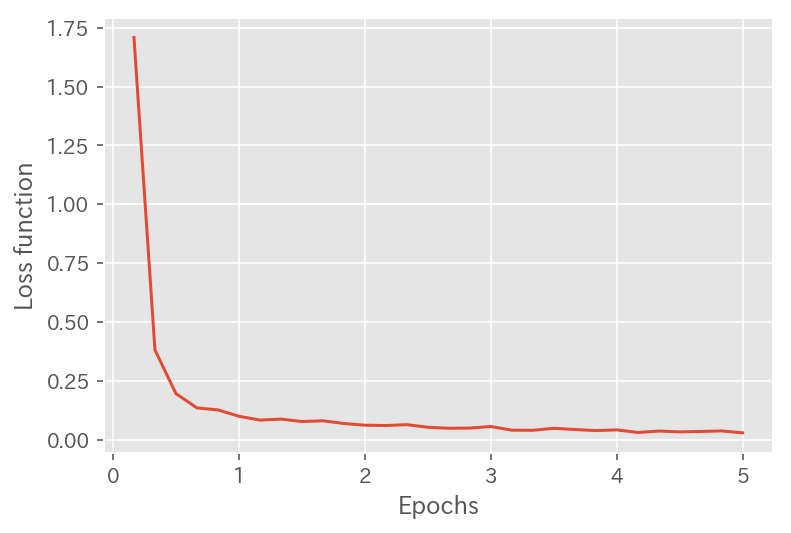

In [24]:
epochs = np.arange(1.0/6.0, 31.0/6.0, 1.0/6.0)
epochs
plt.plot(epochs, loss_fns)
plt.xlabel('Epochs')
plt.ylabel('Loss function')
plt.show()

### Testing the Network with test-data

In [25]:
correct = 0
total = 0

for data in test_loader:
    images, labels = data
    
    # Accuracy Rate
    outputs = net(Variable(images))
    _, predicted = torch.max(outputs.data, 1) # torch.max(input, dim) : 全dim行毎に、maxを取りそのvalueとargのTensorを返す
    total += labels.size(0)
    correct += (predicted == labels).sum()
    
print('Accuracy of the network on the 10000 test images: %4.2lf %%' % (100 * correct / total))

Accuracy of the network on the 10000 test images: 98.77 %


In [26]:
print(correct, total)

9877 10000


### Show images that were mistaken

Pred : 2  /  Ans : 4


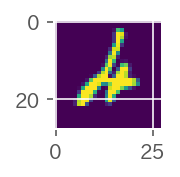

---------------------------------------------
Pred : 8  /  Ans : 9


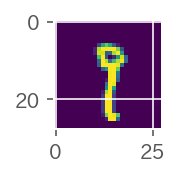

---------------------------------------------
Pred : 0  /  Ans : 6


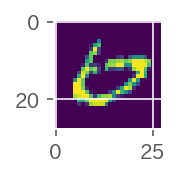

---------------------------------------------
Pred : 5  /  Ans : 3


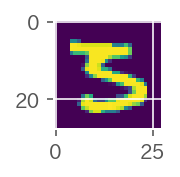

---------------------------------------------
Pred : 8  /  Ans : 4


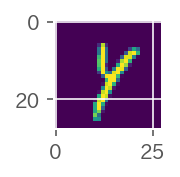

---------------------------------------------


In [27]:
miss = 0
for data in test_loader:
    images, labels = data
    
    outputs = net(Variable(images))
    _, predicted = torch.max(outputs.data, 1) # torch.max(input, dim) : 全dim行毎に、maxを取りそのvalueとargのTensorを返す
    
    # 間違えた画像の表示
    for j in range(len(images)):
        if miss < num_miss_checks and predicted[j] != labels[j]:
            print('Pred : {}  /  Ans : {}'.format(predicted[j], labels[j]))
            figure = images[j].view(28, 28)
            # 描画については、０から のch03/mnist.pyも参照
            plt.figure(figsize=(1, 1))
            plt.imshow(figure.numpy())#, cmap=cm.gray_r)
            plt.show()
            print('---------------------------------------------')
            miss += 1

In [28]:
print(type(train_loader))

<class 'torch.utils.data.dataloader.DataLoader'>


In [29]:
for i, data in enumerate(train_loader, 0):
    inputs, labels = data
    if i == 0:
        print(inputs.size(), type(inputs))
        print(labels.size(), type(inputs))

torch.Size([5, 1, 28, 28]) <class 'torch.FloatTensor'>
torch.Size([5]) <class 'torch.FloatTensor'>


In [30]:
print(train_set.train_data.size(), type(train_set.train_data))

torch.Size([60000, 28, 28]) <class 'torch.ByteTensor'>
